In [77]:
# import dependencies
import ultralytics
import torch
import cv2
import supervision as sv
import matplotlib.pyplot as plt
from ultralytics import YOLO
from collections import defaultdict

In [78]:
# load a pretrained YOLOv8n model
model = YOLO('yolov8n.pt')

In [ ]:
# show video properties
cap = cv2.VideoCapture("traffic.mp4")
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
print(f">>> Video Properties: Width = {width}, Height = {height}, FPS = {fps}")

>>> Video Properties: Width = 1280, Height = 720, FPS = 25.0


In [ ]:
# define a horizontal line with 2 points
START = (420, 460)
END = (1120, 460)

# track history for each object
track_history = defaultdict(lambda: []) # track_history -> {track_id: [pos_0, ..., pos_n]}
crossed_objects = {}

video_info = sv.VideoInfo.from_video_path("traffic.mp4")
with sv.VideoSink("output.mp4", video_info) as sink:
    while cap.isOpened():
        success, frame = cap.read()
        if success:
            results = model.track(
                frame,                      # single video frame
                classes=[2, 3, 5, 7],       # only track selected COCO classes: 2 -> car, 3 -> motorcycle, 5 -> bus, 7 -> truck
                persist=True,               # prevents IDs from resetting every frame, enables true multi-object tracking
                conf=0.5, 
                iou=0.5,
                tracker="bytetrack.yaml"
            )

            # get boxes and track IDs
            boxes = results[0].boxes.xywh.cpu()
            track_ids = [int(t) for t in results[0].boxes.id.cpu()] # unique ID assigned to each detected object

            # draw YOLO annotations
            annotated_frame = results[0].plot()

            # plot the tracks and count objects crossing the line
            for box, track_id in zip(boxes, track_ids):
                x, y, w, h = box.tolist()
                track = track_history[track_id]     # track is a list of past positions for a single tracked object
                track.append((x, y))                # add current positions to the track
                if len(track) > 30:                 # keep only the last 30 historical positions for each object
                    track.pop(0)

                # check if the object crosses the horizontal line (within 5 pixels)
                if START[0] < x < END[0] and abs(y - START[1]) < 5: 
                    if track_id not in crossed_objects:
                        crossed_objects[track_id] = True

                    # highlight the box as red when object crosses the line
                    cv2.rectangle(annotated_frame, (int(x - w/2), int(y - h/2)), (int(x + w/2), int(y + h/2)), (0, 0, 255), 3)

            # draw the line on the frame
            cv2.line(annotated_frame, START, END, (0, 255, 0), 3)

            # write the count of objects on each frame
            count_text = f"Objects crossed: {len(crossed_objects)}"
            cv2.putText(annotated_frame, count_text, (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)

            # write the frame with annotations to the output video
            sink.write_frame(annotated_frame)

        else:
            break

# release the video capture
cap.release()

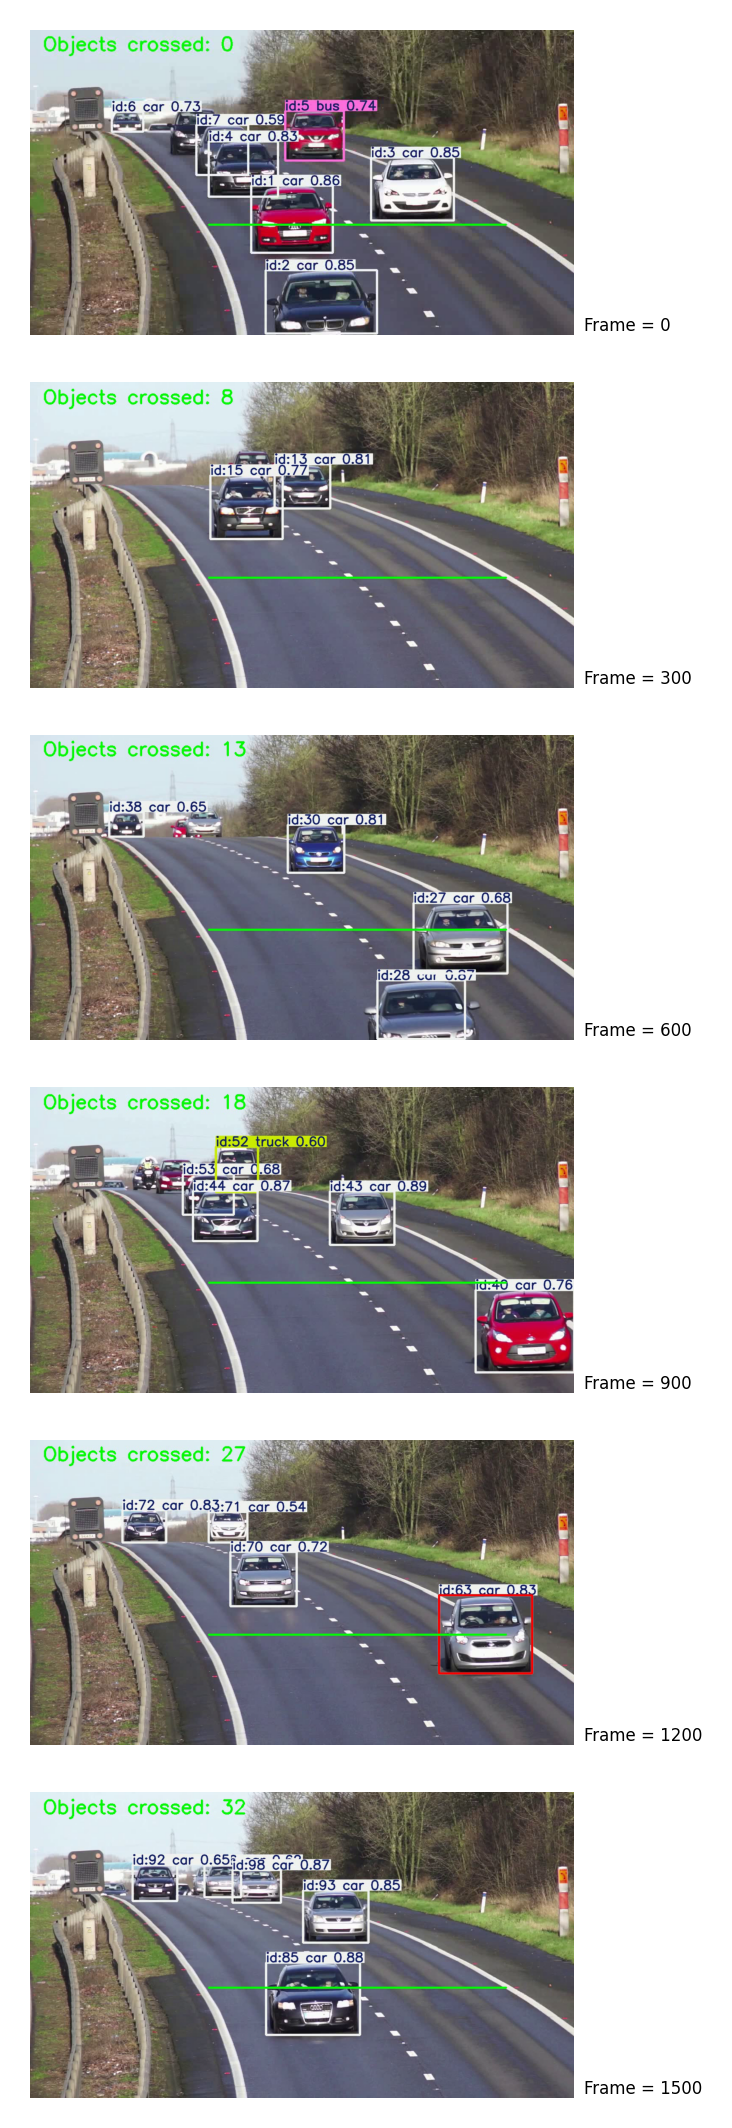

In [ ]:
# visualize annotated video frame
video_path = "output.mp4"
frame_index = [idx for idx in range(0, 1501, 300)]

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError(">>> Error: Could not open video.")

fig, axs = plt.subplots(len(frame_index), 1, figsize=(12.8, 7.2), dpi=300)

for idx, frame_no in enumerate(frame_index):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
    success, frame = cap.read()

    if not success:
        print(f">>> Error: Could not read frame {frame_no}")
        continue

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    axs[idx].imshow(frame_rgb)
    axs[idx].axis("off")
    axs[idx].text(
        1.02, 0.03, 
        f"Frame = {frame_no}",
        transform=axs[idx].transAxes,
        va="center",
        fontsize=4
    )

cap.release()

plt.tight_layout()
plt.show()